# Learning-based analysis and design of Mixed therapy of cancer

This notebook implements a learning-based methodology for the analysis and the design of a mixed therpay of cancer based on highly uncertain model's parameters. This notebook uses a python module (mixed_therapy.py) that provides utlitites for the development contained in this notebook. This modules has been already used (using the generate_learning_data function) to generate learning data with seven levels of model's parameters uncertainties: 0%, 10%, 20%, 30%, 40%,  50% and 80%. For each of these level 10,000 samples are generated containing (initial state, parameter vector and control parameters setting). The learning data is generated using the function generate_learning_data of the mixed_therapy.py module.



## Dowload the learning data previously generated

This cell downloads the previoulsly computed learning data and constructs a single dataframe to which columns are added which are: 
- the final tumor size $T_f$, 
- the success inficator of tumor contraction success_T
- the success in mainting the health constraint satisfied success_C
- the amounts vI_usage, vL_usage and vM_usage of drug use during the therapy


In [4]:
from mixed_therapy import *
import pickle
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Rate of tumor contraction to define success_T
gamma_c = 1e-2

# parameter of success in maintaining the health constraint
rho = 0.5

# The part of test to be used in the validation of the learned predictors
test_size = 0.3

# Create the dataframes for each file in the learning data 
# the files in the list are created using the function 
# generate_learning_data function of the mixed_therapy.py module 
# this has been done outside the present notebook.

files = ['R_0.8_0.8_uniform.pkl', 
         'R_0.5_0.5_uniform.pkl',
         'R_0.4_0.4_uniform.pkl',
         'R_0.3_0.3_uniform.pkl',
         'R_0.2_0.2_uniform.pkl',
         'R_0.1_0.1_uniform.pkl',
         'R_0_0_uniform.pkl']

# create the dictionary of dataframes for all the pre-computed clouds 
# of simulations  under different uncertainty level. 
# This dictionary is dic_df.

keys = [80, 50, 40, 30, 20, 10, 0]
dic_df = {}
already_done = True
if not already_done:
    for i in range(len(keys)):
        R = pickle.load(open(files[i], 'rb'))
        df = create_dataframe_from_result(R)
        dic_df[keys[i]] = df

    pickle.dump(dic_df, open('dic_df.pkl', 'wb'))
    
dic_df = pickle.load(open('dic_df.pkl', 'rb'))
df_therapy = pd.concat([dic_df[k] for k in keys], axis=0)

df_therapy['success_T'] = np.divide(df_therapy['Tf'], df_therapy.x1) <= gamma_c 
df_therapy['success_C'] = df_therapy.lower_C >= rho
df_therapy


,x1,x2,x3,x4,x5,x6,a,b,c,d,...,T_stop,Treatment_duration,basic_period,Tf,lower_C,vI_usage,vL_usage,vM_usage,success_T,success_C
0,2.171130e+06,0.001021,4.900276e+01,8.301371e+10,0.001,0.001,0.217334,6.439315e-10,9.936612e-11,1.849701,...,1550.888693,0.503704,0.5,1.563908e+01,0.122999,0.062831,0.062831,12.500000,True,False
1,5.742344e+08,4.332878,1.498090e-02,4.217765e+10,0.001,0.001,0.125783,8.952515e-10,2.133018e-11,1.690553,...,1558.900317,0.234490,0.5,5.731047e+08,0.349643,6.666667,6.666667,0.000000,False,False
2,3.874042e+07,103.677429,9.012237e+05,3.400022e+10,0.001,0.001,0.203652,1.161129e-09,2.467359e-11,1.331225,...,30439.675150,0.795953,0.5,9.304463e+07,0.062537,30.000000,30.000000,0.000000,False,False
3,9.255420e+07,0.015677,5.355008e+01,4.823039e+10,0.001,0.001,0.190457,1.593367e-09,1.137543e-10,2.187175,...,42800.785513,0.567737,1.0,8.655558e+07,0.543372,21.666667,21.666667,0.000000,False,True
4,1.217567e+05,0.783185,2.418469e+02,6.926227e+10,0.001,0.001,0.577033,7.576544e-10,1.056334e-10,2.040777,...,1699.527424,0.779964,1.0,1.131080e+00,0.555903,0.004207,0.004207,3.750000,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.721309e+06,218.481384,6.464573e+02,4.266143e+10,0.001,0.001,0.431000,1.020000e-09,6.410000e-11,2.340000,...,46027.990258,0.636738,1.0,3.424613e+00,0.365166,0.119567,0.119567,0.000000,True,False
9996,1.402130e+07,0.010884,2.235328e+06,1.186400e+11,0.001,0.001,0.431000,1.020000e-09,6.410000e-11,2.340000,...,1584.948602,0.446790,0.5,4.788576e+00,0.238878,0.491649,0.491649,10.416667,True,False
9997,9.836132e+06,140.172834,7.054542e+05,7.566885e+10,0.001,0.001,0.431000,1.020000e-09,6.410000e-11,2.340000,...,7315.710186,0.702143,2.0,6.784355e+00,1.321905,0.160084,0.160084,0.208333,True,True
9998,9.414450e+07,0.948454,4.740740e+04,6.745424e+10,0.001,0.001,0.431000,1.020000e-09,6.410000e-11,2.340000,...,14183.618320,0.301477,0.5,1.176669e+08,1.035653,10.000000,10.000000,10.000000,False,True


In [9]:
df_therapy.c_d

0       1.123593
1       0.862125
2       1.224845
3       0.852747
4       1.210119
          ...   
9995    1.113348
9996    1.490211
9997    1.452656
9998    1.121160
9999    0.883121
Name: c_d, Length: 70000, dtype: float64

## Fit a model tto classify successful conditions regarding tumor contraction

### Using all the features

In [2]:
# Define the columns of features to be used in the model

col_2_exclude = ['Tf', 'lower_C', 'vI_usage', 'vL_usage', 'vM_usage', 'success_T', 'success_C']
colX = [c for c in df_therapy.columns if c not in col_2_exclude]

def assess_success(label, colX, n_estimators=100, max_leaf_nodes=2000):
    X = df_therapy[colX].values
    if label == 'T':
        y = df_therapy.success_T.values
    else:
        y = df_therapy.success_C.values

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)
    cl = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, n_estimators=n_estimators)
    yhat = cl.fit(Xtrain, ytrain).predict(Xtest)

    C = confusion_matrix(ytest, yhat, labels=cl.classes_)
    Cn = confusion_matrix(ytest, yhat, labels=cl.classes_, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=C, display_labels=cl.classes_)
    disp.plot()
    plt.show()
    disp = ConfusionMatrixDisplay(confusion_matrix=Cn, display_labels=cl.classes_)
    disp.plot()
    plt.show()
    return cl


### Results for the assessment of the tumor contraction


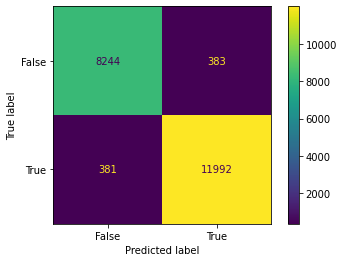

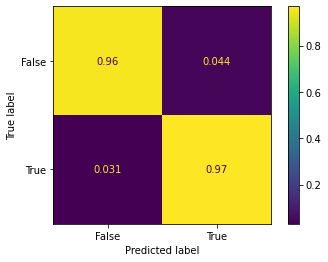

In [3]:
cl_contraction_all = assess_success('T', colX)


### Results for the assessment of the satisfaction of the health constraint


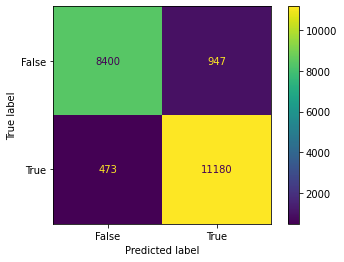

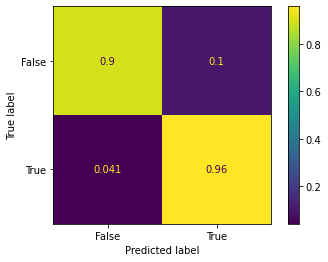

In [4]:
cl_health_all = assess_success('C', colX)


### Selecting the only important features using RandomForestClassifier.features_importances_ attribute

### Tumor contraction

['x1' 'd' 'x4' 'l' 'a']


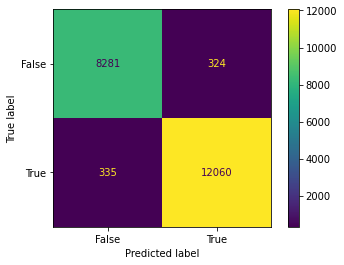

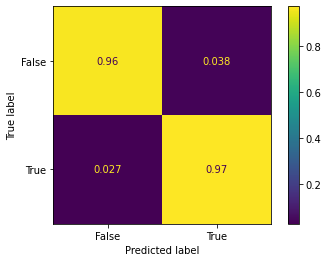

In [5]:
nb_features = 5
df = pd.DataFrame(colX, columns=['Features'])
df['importance'] = cl_contraction_all.feature_importances_
df = df.sort_values(by='importance', ascending=False).reset_index(drop=True)
colX_contraction_important = df.iloc[0:nb_features]['Features'].values
print(colX_contraction_important)

cl_contraction_selected = assess_success('T', colX=colX_contraction_important)


['x4' 'x1' 'r' 'beta_C' 'Treatment_duration' 'KC' 'T_stop']


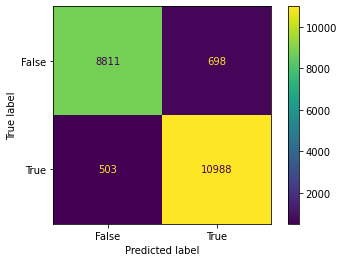

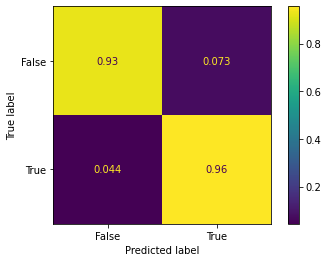

In [6]:
nb_features = 7
df = pd.DataFrame(colX, columns=['Features'])
df['importance'] = cl_health_all.feature_importances_
df = df.sort_values(by='importance', ascending=False).reset_index(drop=True)
colX_health_important = df.iloc[0:nb_features]['Features'].values
print(colX_health_important)
cl_health_selected = assess_success('C', colX=colX_health_important)




## Models for drug usage during therapy

### Model for chemotherapy usage 

In [7]:
ind = [i for i in df_therapy.index if df_therapy.iloc[i]['success_T'] ]

colX_both = list(set(list(colX_contraction_important)+list(colX_health_important)))
X = df_therapy.loc[ind, colX_both].values
y = df_therapy.loc[ind, 'vM_usage'].values

reg_M = RandomForestRegressor(n_estimators=100)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)
yhat  = reg_M.fit(Xtrain, ytrain).predict(Xtest)

ytest_M = ytest.copy()
yhat_M = yhat.copy()

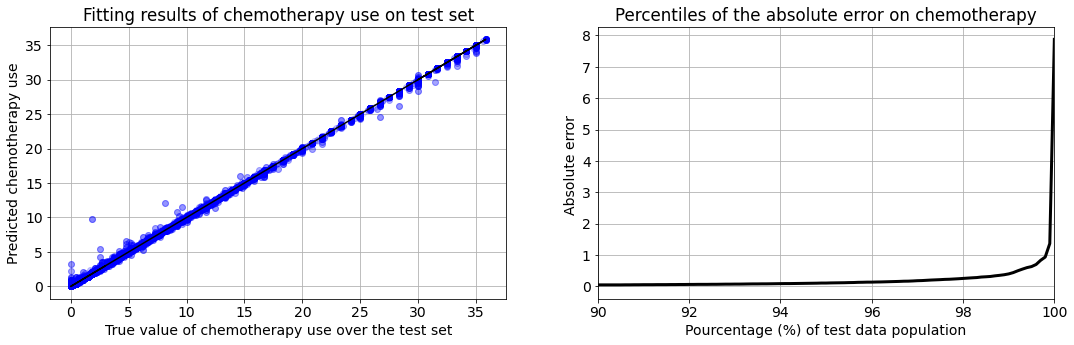

In [8]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(ncols=2, figsize=(18,5))
ax[0].plot(ytest, yhat, 'bo', alpha=0.1)
ax[0].plot(ytest, ytest, 'k-')
ax[0].grid(True)
ax[0].set_xlabel('True value of chemotherapy use over the test set')
ax[0].set_ylabel('Predicted chemotherapy use')
ax[0].set_title('Fitting results of chemotherapy use on test set') 

q = np.linspace(0,100,1001)
perc = np.percentile(abs(ytest-yhat), q)
ax[1].plot(q, perc, 'k-', linewidth=3)
ax[1].grid(True)
ax[1].set_xlim([90,100]);
ax[1].set_xlabel('Pourcentage (%) of test data population')
ax[1].set_ylabel('Absolute error ')
ax[1].set_title('Percentiles of the absolute error on chemotherapy') 

plt.show()



### Model for Immuno-Therapy-I usage 

In [9]:
ind = [i for i in df_therapy.index if df_therapy.iloc[i]['success_T']]
X = df_therapy.loc[ind, colX_both].values
y = df_therapy.loc[ind, 'vI_usage'].values

reg_I = RandomForestRegressor()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)
yhat  = reg_I.fit(Xtrain, ytrain).predict(Xtest)

ytest_I = ytest.copy()
yhat_I = yhat.copy()


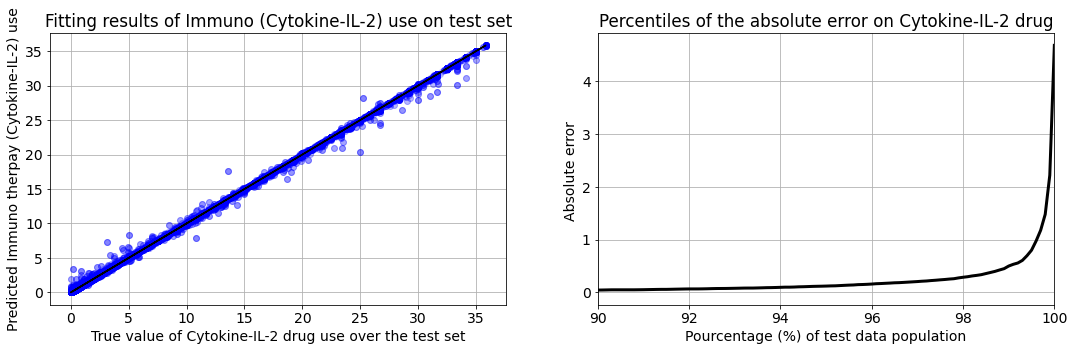

In [10]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(ncols=2, figsize=(18,5))
ax[0].plot(ytest, yhat, 'bo', alpha=0.1)
ax[0].plot(ytest, ytest, 'k-')
ax[0].grid(True)
ax[0].set_xlabel('True value of Cytokine-IL-2 drug use over the test set')
ax[0].set_ylabel('Predicted Immuno therpay (Cytokine-IL-2) use')
ax[0].set_title('Fitting results of Immuno (Cytokine-IL-2) use on test set') 

q = np.linspace(0,100,1001)
perc = np.percentile(abs(ytest-yhat), q)
ax[1].plot(q, perc, 'k-', linewidth=3)
ax[1].grid(True)
ax[1].set_xlim([90,100]);
ax[1].set_xlabel('Pourcentage (%) of test data population')
ax[1].set_ylabel('Absolute error ')
ax[1].set_title('Percentiles of the absolute error on Cytokine-IL-2 drug') 

plt.show()


### Model for Immuno-Therapy-II usage 

In [11]:
ind = [i for i in df_therapy.index if df_therapy.iloc[i]['success_T']]
X = df_therapy.loc[ind, colX_both].values
y = df_therapy.loc[ind, 'vL_usage'].values

reg_L = RandomForestRegressor()

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)
yhat  = reg_L.fit(Xtrain, ytrain).predict(Xtest)

ytest_L = ytest.copy()
yhat_L = yhat.copy()

Text(0.5, 1.0, 'Percentiles of the absolute error on (CD8+T) related drug')

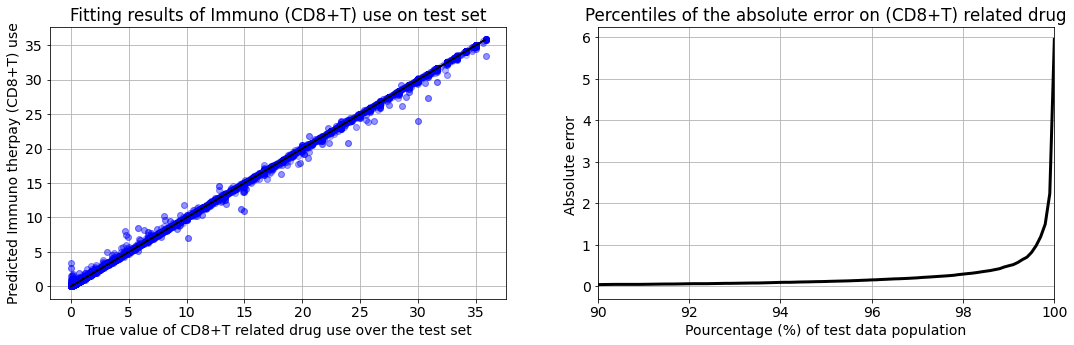

In [12]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(ncols=2, figsize=(18,5))
ax[0].plot(ytest, yhat, 'bo', alpha=0.1)
ax[0].plot(ytest, ytest, 'k-')
ax[0].grid(True)
ax[0].set_xlabel('True value of CD8+T related drug use over the test set')
ax[0].set_ylabel('Predicted Immuno therpay (CD8+T) use')
ax[0].set_title('Fitting results of Immuno (CD8+T) use on test set') 

q = np.linspace(0,100,1001)
perc = np.percentile(abs(ytest-yhat), q)
ax[1].plot(q, perc, 'k-', linewidth=3)
ax[1].grid(True)
ax[1].set_xlim([90,100]);
ax[1].set_xlabel('Pourcentage (%) of test data population')
ax[1].set_ylabel('Absolute error ')
ax[1].set_title('Percentiles of the absolute error on (CD8+T) related drug') 


## Plot all the drug regression resuls on the same plot 

Text(0.5, 1.0, 'Percentiles of the absolute error')

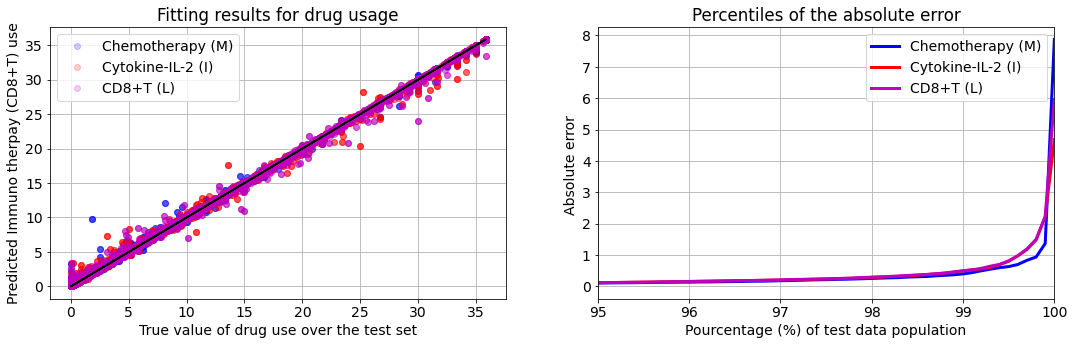

In [13]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(ncols=2, figsize=(18,5))
#---
ax[0].plot(ytest_M, yhat_M, 'bo', alpha=0.2)
ax[0].plot(ytest_I, yhat_I, 'ro', alpha=0.2)
ax[0].plot(ytest_L, yhat_L, 'mo', alpha=0.2)
ax[0].legend(['Chemotherapy (M)', 'Cytokine-IL-2 (I)', 'CD8+T (L)'])
ax[0].plot(ytest_M, ytest_M, 'k-')
ax[0].plot(ytest_I, ytest_I, 'k-')
ax[0].plot(ytest_L, ytest_L, 'k-')
#---
ax[0].grid(True)
ax[0].set_xlabel('True value of drug use over the test set')
ax[0].set_ylabel('Predicted Immuno therpay (CD8+T) use')
ax[0].set_title('Fitting results for drug usage')


q = np.linspace(0,100,1001)
perc_M = np.percentile(abs(ytest_M-yhat_M), q)
perc_I = np.percentile(abs(ytest_I-yhat_I), q)
perc_L = np.percentile(abs(ytest_L-yhat_L), q)
ax[1].plot(q, perc_M, 'b-', linewidth=3)
ax[1].plot(q, perc_I, 'r-', linewidth=3)
ax[1].plot(q, perc_L, 'm-', linewidth=3)
ax[1].legend(['Chemotherapy (M)', 'Cytokine-IL-2 (I)', 'CD8+T (L)'])

ax[1].grid(True)
ax[1].set_xlim([95,100]);
ax[1].set_xlabel('Pourcentage (%) of test data population')
ax[1].set_ylabel('Absolute error ')
ax[1].set_title('Percentiles of the absolute error') 


## Saving all the results 

In [14]:
# the instance sol contains all the information that enables
# to use the so fitted predictor into a functions that can 
# be used to derive control design and dashboards. 

sol = Result()
sol.cl_contraction_all = cl_contraction_all
sol.cl_contraction_selected = cl_contraction_selected
sol.cl_health_all = cl_health_all
sol.cl_health_selected = cl_health_selected
sol.colX = colX
sol.colX_contraction_important = colX_contraction_important
sol.colX_health_important = colX_health_important
sol.colX_both = colX_both
sol.reg_M = reg_M
sol.reg_I = reg_I
sol.reg_L = reg_L
sol.df_therapy = df_therapy

save = True
if save:
    pickle.dump(sol, open('solution_therapy_2.pkl', 'wb'))
    

In [15]:
sol = pickle.load(open('solution_therapy_2.pkl', 'rb'))

X_health = sol.df_therapy[sol.colX_health_important].values
is_C_negative = sol.df_therapy.lower_C.values < 0
df = pd.DataFrame(is_C_negative, columns=['TN'])
prediction = sol.cl_health_selected.predict(X_health)
df['prediction'] = prediction
number_of_truly_bad = np.sum(is_C_negative)
number_of_predicted_good_among_bad = np.sum(df[df.TN == True]['prediction'] == True)
ratio = number_of_predicted_good_among_bad / number_of_truly_bad
print(ratio)


0.03069590085795996


In [16]:
print(sol.colX_contraction_important)
print(sol.colX_health_important)
print(sol.colX_both)


['x1' 'd' 'x4' 'l' 'a']
['x4' 'x1' 'r' 'beta_C' 'Treatment_duration' 'KC' 'T_stop']
['x4', 'x1', 'r', 'Treatment_duration', 'l', 'beta_C', 'd', 'KC', 'a', 'T_stop']


## Using the learned model to derive dashboards of success and drug usages

### Computing the boundary of success

In [287]:
%%time
# this part of the notebook consider that the remaining free parameter of the controller are 
# xp = (r, beta_C, Treatment_duration, T_stop)
# note that the treament_duration is kappa in the paper

from itertools import product

# doanload the fitted solutions 
sol = pickle.load(open('solution_therapy_2.pkl', 'rb'))

# Define the set of control options

r_set = {0.1, 5, 10}
beta_C_set = {1.2, 1.5, 2}
treatment_duration_set = {0.2, 0.5, 0.9}
T_stop_set = {10, 100, 1000}
S = set(product(r_set, beta_C_set, treatment_duration_set, T_stop_set))
control_options = [list(s) for s in S]

# Number of samples for n_Theta=81<=100 and eta=0.05
n_samples = 386
mode = "uniform"
alpha = 0.4

# Generate the cloud of initial states and model's parameters 
X0 = generate_x0(n_samples)
df_p_model = create_df_p_model(mode=mode, sigma=alpha, alpha=alpha, n_samples=n_samples)
c = Context(X0=X0, df_p_model=df_p_model, sol=sol)

def is_success(r):
    
    # check for a dingle control option if less than 1 of the samples 
    # does not satisfy the health and the contraction constraint. 
    # r being the output of the predict_over_cloud function. 
    
    df_H = pd.DataFrame(list(r.health_condition), columns=['Health'])
    df_C = pd.DataFrame(list(r.contraction_condition), columns=['Contraction'])
    df_both = pd.concat([df_H, df_C], axis=1)
    df_success = df_both.Health & df_both.Contraction
    return np.sum(df_success.values)>=len(df_success)-1

def evaluate(T, C):
    
    for i in range(len(c.X0)):
        c.X0[i][0], c.X0[i][3] = T, C
    lesRs = {i:predict_over_cloud(control_options[i], c) 
             for i in range(len(control_options))}
    success = [is_success(lesRs[i]) for i in range(len(control_options))]
    cost_of_drug = [np.mean(lesRs[i].QM+lesRs[i].QI+lesRs[i].QL) 
                    for i in range(len(control_options))]
    QM = [np.mean(lesRs[i].QM) for i in range(len(control_options))]
    QI = [np.mean(lesRs[i].QI) for i in range(len(control_options))]
    QL = [np.mean(lesRs[i].QL) for i in range(len(control_options))]
    lesi = [i for i in range(len(control_options))]
    df_dash = pd.DataFrame([success, cost_of_drug, QM, QI, QL, lesi], 
                           index=['success', 'cost', 'QM', 'QI', 'QL', 'control_option']).T
    
    result = {'success':False, 'control_options':None, 'QM':None, 'QI':None, 'QL':None, 'cost':None}
    
    if np.sum(df_dash.success.values==True)>1:
        return df_dash.groupby(by='success').get_group(True).sort_values(by='cost').iloc[0].to_dict()
    else:
        return result
    
def find_T(C):
    
    Tmin = 1.0
    Tmax = 1e8
    while (Tmax-Tmin>1e3):
        Tmean = (Tmin+Tmax)/2
        R = evaluate(Tmean, C)
        if R['success']:
            Tmin = Tmean
        else:
            Tmax = Tmean
            
        print([Tmin, Tmean, Tmax])
        
    R = evaluate(Tmin, C)
    R['T'] = Tmin
    
    return R
        
if 0:
    coeffs_C = np.linspace(1.51, 5, 20)    
    Rmax = {str(coeff):0 for coeff in coeffs_C}
    for coeff in coeffs_C:
        print('------------------')
        print(coeff)
        print('------------------')    
        Rmax[str(coeff)] = find_T(coeff * ModelParam().C_min)


CPU times: user 334 ms, sys: 486 ms, total: 821 ms
Wall time: 886 ms


In [288]:
import pickle
name = f'R_max_{alpha}.pkl'
pickle.dump(Rmax, open(name, 'wb'))

### Computing the dashboard of drug usage in the success-region

In [289]:
Cs = set(np.linspace(1.51, 5, 20) * ModelParam().C_min)
Ts = set(np.logspace(3, 8, 50))
CT = set(product(Cs, Ts))
Initial_conditions = [tuple(ct) for ct in CT]

Resultats = {ct:None for ct in Initial_conditions}
for ct in tqdm(Initial_conditions):
    C, T = ct[0], ct[1]
    Resultats[ct] = evaluate(T, C)
    
pickle.dump(Resultats, open(f'Resultats_{alpha}.pkl', 'wb'))    

100%|████████████████████████████████████| 1000/1000 [1:04:25<00:00,  3.87s/it]


## Ploting the dashboards 

In [3]:
ModelParam().C_min/1e10


3.125